## 주제: 🍕 or !🍕
---
출처: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import random # random seed 설정용
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D

- 데이터 로딩 및 준비

In [2]:
hr_image = [] # 이미지 담을 리스트
target = [] # 타겟 담을 리스트
file_list = os.listdir('./pizza_not_pizza/') # 파일 경로

for name in file_list:
    PATH = r'./pizza_not_pizza/'+name+'/'
    # 폴더 내 모든 이미지 읽고 저장
    for filename in os.listdir(PATH):
        target.append(name)
        img = cv2.imread(PATH + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 이미지 색 변환
        resize_img = cv2.resize(img, (224, 224), fx=0.3, fy=0.7, interpolation=cv2.INTER_AREA) 
        hr_image.append(resize_img)

# numpy 배열 형태로 저장
target = np.array(target)
hr_image = np.array(hr_image)
hr_image.shape

(1966, 224, 224, 3)

In [3]:
# 이미지 확인 함수
def showImage(data1,data2,num):
    for i in range(num, num+3):
        if data2[i] == 'pizza':
            name = 'pizza'
            plt.title('name: {}\n'.format(name))
            plt.imshow(data1[i])
            plt.show()
        else: 
            name = 'not_pizza'
            plt.title('name: {}\n'.format(name))
            plt.imshow(data1[i])
            plt.show()

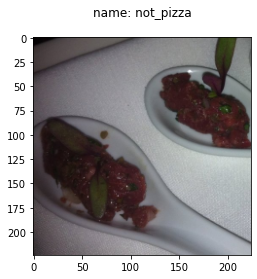

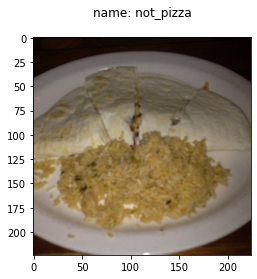

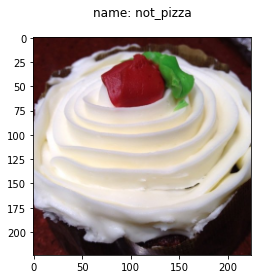

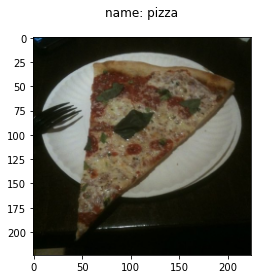

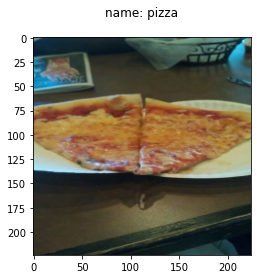

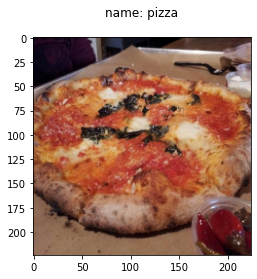

In [4]:
showImage(hr_image, target, 0)
showImage(hr_image, target, 1000)

- 학습/테스트 데이터 준비

In [5]:
target = target.reshape(-1,1)
target.shape

(1966, 1)

In [6]:
# 8:2 비율
train_X, test_X, train_y, test_y = train_test_split(hr_image, target,
                                                  stratify=target,
                                                  test_size=0.2,
                                                  random_state=11)

In [7]:
train_X.shape, test_X.shape

((1572, 224, 224, 3), (394, 224, 224, 3))

In [8]:
# 스케일링
train_scaled_X = train_X/255.0
test_scaled_X = test_X/255.0

- not 피자: 0, 피자: 1

In [9]:
# 원핫인코딩
ohe = OneHotEncoder()
train_ohe_y = ohe.fit_transform(train_y)
test_ohe_y = ohe.transform(test_y)

In [10]:
train_ohe_y = train_ohe_y.toarray()
test_ohe_y = test_ohe_y.toarray()

### 방법 1) CNN
___

[1] 모델 구성

In [19]:
random.set_seed(11)

In [30]:
model = Sequential()

In [31]:
# 이미지 특징 추출 Layer => 첫 번째 입력값 설정
model.add(Conv2D(12, kernel_size=3, padding='same', input_shape=(224, 224, 3))) # 3차원
# 이미지 특징 다운샘플링 Layer => MaxPool2D
model.add(MaxPool2D())
model.add(Conv2D(12, kernel_size=3, padding='same'))
model.add(MaxPool2D())
# 1차원으로 데이터 형태 변환 Layer => Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid')) # 1차원

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 12)      336       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 12)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 12)      1308      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37632)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2408512   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

[2] 모델 생성 및 학습

In [33]:
# 검증 데이터에 대한 loss 값이 3번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=3)

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [35]:
hist = model.fit(train_scaled_X, train_ohe_y,
                 batch_size=36,
                 validation_split = 0.2,
                 epochs=20,
                 callbacks=[stopCB])

Epoch 1/20
35/35 [==============================] - 15s 418ms/step - loss: 1.0194 - accuracy: 0.5855 - val_loss: 0.6623 - val_accuracy: 0.6667
Epoch 2/20
35/35 [==============================] - 14s 399ms/step - loss: 0.6279 - accuracy: 0.6770 - val_loss: 0.6520 - val_accuracy: 0.6349
Epoch 3/20
35/35 [==============================] - 14s 408ms/step - loss: 0.6155 - accuracy: 0.6587 - val_loss: 0.6121 - val_accuracy: 0.7048
Epoch 4/20
35/35 [==============================] - 14s 401ms/step - loss: 0.5861 - accuracy: 0.7049 - val_loss: 0.6048 - val_accuracy: 0.6984
Epoch 5/20
35/35 [==============================] - 17s 480ms/step - loss: 0.5538 - accuracy: 0.7232 - val_loss: 0.6320 - val_accuracy: 0.6825
Epoch 6/20
35/35 [==============================] - 20s 559ms/step - loss: 0.5450 - accuracy: 0.7327 - val_loss: 0.5950 - val_accuracy: 0.7143
Epoch 7/20
35/35 [==============================] - 17s 498ms/step - loss: 0.5188 - accuracy: 0.7438 - val_loss: 0.6064 - val_accuracy: 0.7111

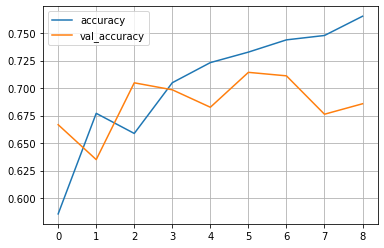

In [36]:
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

[3] 모델 평가

In [37]:
model.evaluate(test_scaled_X, test_ohe_y)

13/13 [==============================] - 1s 103ms/step - loss: 0.6067 - accuracy: 0.7335


[0.6067091226577759, 0.7335025668144226]

#### 방법 2) MobileNet

---

[1] 모델 구성

In [11]:
random.set_seed(11)

In [12]:
mobilenet=MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

In [13]:
model2=Sequential()
model2.add(mobilenet)
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(2,activation='softmax'))

In [14]:
model2.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

[2] 모델 생성 및 학습

In [15]:
early_stopping = EarlyStopping(min_delta=0.01, patience=2, restore_best_weights=True)

In [16]:
hist2 = model2.fit(train_scaled_X, train_ohe_y,
                  validation_split=0.2,
                  epochs=15,
                  callbacks=[early_stopping])

Epoch 1/15
40/40 [==============================] - 121s 3s/step - loss: 0.5416 - accuracy: 0.7168 - val_loss: 0.5433 - val_accuracy: 0.7143
Epoch 2/15
40/40 [==============================] - 116s 3s/step - loss: 0.2343 - accuracy: 0.9014 - val_loss: 0.1989 - val_accuracy: 0.9175
Epoch 3/15
40/40 [==============================] - 116s 3s/step - loss: 0.1582 - accuracy: 0.9324 - val_loss: 0.2104 - val_accuracy: 0.9048
Epoch 4/15
40/40 [==============================] - 117s 3s/step - loss: 0.1021 - accuracy: 0.9658 - val_loss: 0.1956 - val_accuracy: 0.9206


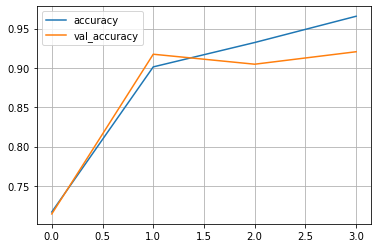

In [17]:
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

[3] 모델 평가

In [19]:
model2.evaluate(test_scaled_X, test_ohe_y)

13/13 [==============================] - 6s 486ms/step - loss: 0.1897 - accuracy: 0.9289


[0.18967732787132263, 0.9289340376853943]

[4] 새로운 이미지로 예측

In [20]:
import PIL.Image as pilimg

# 새로운 사진 예측 함수
def pre_print(imagefile):
    pre_val=['😔not pizza😔','🍕pizza🍕']

    # 이미지 불러오기
    test_image=pilimg.open(imagefile).resize((224,224))
    test_image_arr=np.array(test_image)
    test_image_arr = test_image_arr/255.0

    # 이미지 그래프로 그리기
    plt.imshow(test_image)
    plt.show()

    # 예측
    result=np.round(model2.predict(test_image_arr.reshape(-1,224,224,3)),2)
    print(f"""예측값: {result}\n종류: {pre_val[result.argmax()]}""")

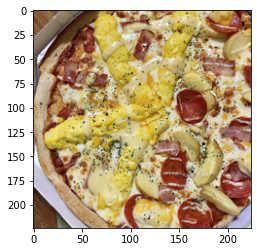

예측값: [[0. 1.]]
종류: 🍕pizza🍕


In [21]:
pre_print('피자1.jpg')

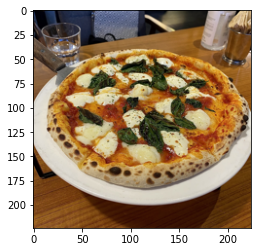

예측값: [[0. 1.]]
종류: 🍕pizza🍕


In [22]:
pre_print('피자3.jpg')

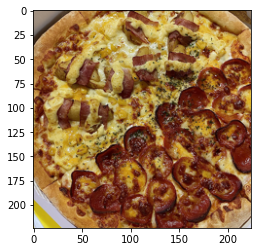

예측값: [[0. 1.]]
종류: 🍕pizza🍕


In [23]:
pre_print('피자4.jpg')

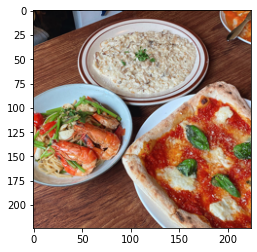

예측값: [[0.32 0.68]]
종류: 🍕pizza🍕


In [24]:
pre_print('피자파스타1.jpg')

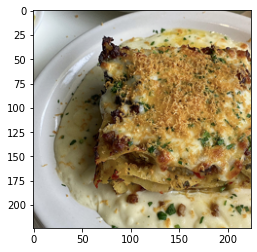

예측값: [[0.14 0.86]]
종류: 🍕pizza🍕


In [25]:
pre_print('라자냐.jpg')

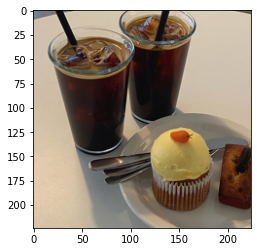

예측값: [[0.99 0.01]]
종류: 😔not pizza😔


In [26]:
pre_print('커피.jpg')

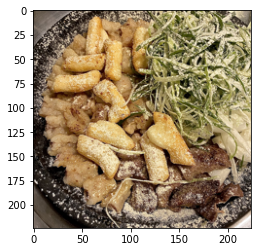

예측값: [[0.65 0.35]]
종류: 😔not pizza😔


In [27]:
pre_print('곱창.jpg')

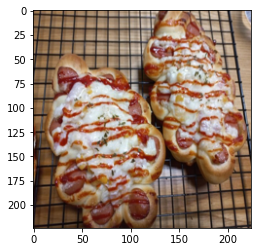

예측값: [[0.04 0.96]]
종류: 🍕pizza🍕


In [28]:
pre_print('피자빵.jfif')

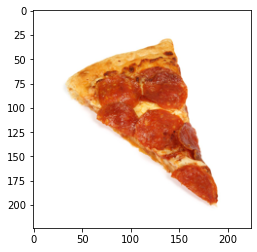

예측값: [[0.14 0.86]]
종류: 🍕pizza🍕


In [29]:
pre_print('피자한조각.jpg')

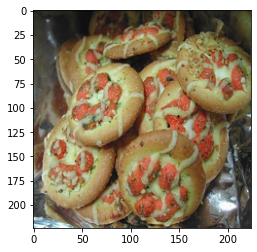

예측값: [[0.25 0.75]]
종류: 🍕pizza🍕


In [30]:
pre_print('이구동성.jfif')

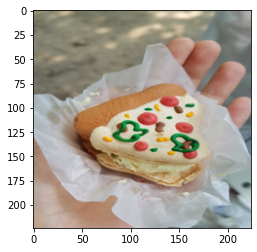

예측값: [[0.95 0.05]]
종류: 😔not pizza😔


In [32]:
pre_print('피자마카롱.jfif')

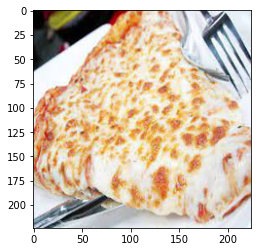

예측값: [[0.02 0.98]]
종류: 🍕pizza🍕


In [33]:
pre_print('코스트코.jfif')

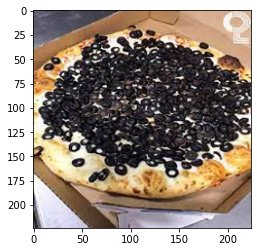

예측값: [[0.06 0.94]]
종류: 🍕pizza🍕


In [34]:
pre_print('올리브.jfif')

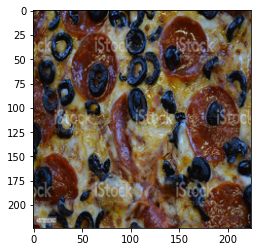

예측값: [[0.01 0.99]]
종류: 🍕pizza🍕


In [36]:
pre_print('근접.jpg')

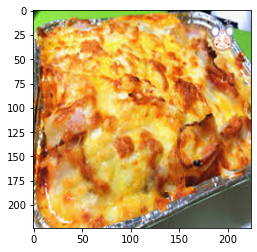

예측값: [[0.01 0.99]]
종류: 🍕pizza🍕


In [38]:
pre_print('오븐_스파게티.jfif')

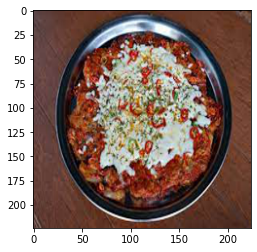

예측값: [[0.17 0.83]]
종류: 🍕pizza🍕


In [41]:
pre_print('치즈김치전jfif.jfif')